**Gruppe:** 0420                   

**Gruppemedlemmer:** 10114, 10035, 10102, 10038
# Prosjekt 2: TMA4320
* **Innleveringsfrist:** Mandag 9. mars, 2020, kl 1400



Introduksjon
----


In [20]:
import sys  
sys.path.insert(0, './py_script')

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import scipy as sp
import loader as ld
import spirals as sp
from plotting import plot_progression, plot_model, plot_separation
import random as rn

rng = np.random.randn

K = 15  # Antall lag
d = 2  # Antall piksel-elementer til hvert bilde. Hvert bilde er stablet opp i en vektor av lengde d
I = 200  # Antall bilder
h = 0.1  # Skrittlengde i transformasjonene
Wk = rng(K, d, d)
w = rng(d)
mu = rng(1)
one = np.ones(I)
bk = rng(d, K)
U0 = np.array ((Wk, bk, w, mu))
y0, C1 = sp.get_data_spiral_2d(I)
C = np.reshape(C1, I)

**Hjelpefunksjoner: Def av variabler for $Y_0$ og $Y_{k+1}$**

In [39]:
def eta(x): return 1 / 2 * (1 + np.tanh(x / 2))
def d_eta(x): return (1-(np.tanh(x/2))**2)/4
def sigma(x): return np.tanh(x)
def d_sigma(x): return 1 - (np.tanh(x))**2
def Z(x, w, mu, I=I): return eta(np.transpose(x) @ w + mu * np.ones(I))  # x = siste Y_K
def J(Z, c, yk, w, mu): return .5*(la.norm(Z(yk, w, mu) - c))**2

**Definisjon av $Y_{k}$**\
Hvor Y_k er np.array hvor ellementene i arrayen er matrise med alle blidene til hvert lag

In [47]:
def YK(y0, K=K, sigma=sigma, h=h, Wk=Wk, bk=bk,I=I):
    Y_out = np.random.rand(K, d, I)
    Y = y0
    Y_out[0] = y0
    for k in range (1, K):
        # bk er en kolonnevektor fra b, men leses som radvektor etter at vi har hentet den ut. Derfor transponerer vi
        # Vi ganger med I for å få en matrise, som etter å ha transponert, blir en matrise med I bk-kolonnevektorer.
        # Må gjøre det slik for at adderingen skal funke
        # bk[:, k] leses: alle rader, i kolonne k. Henter altså ut kolonnevektor k fra matrisen bk
        X = Wk[k] @ Y + np.array([bk[:, k]] * I).transpose()
        Y_out[k] = Y + h * sigma(X)
        Y = Y_out[k]
    return Y_out

**Gradientberegninger, optimering og Adams algorithm:**

In [58]:
def gradient(wk, bk, w, mu, y, c, I=I):
    j_mu = d_eta(np.transpose(np.transpose(y[-1])@ w + mu * np.ones(I))) @ (Z(y[-1], w, mu, I) - c)
    j_w = y[-1] @ ((Z(y[-1], w, mu, I) - c) * d_eta(np.transpose(np.transpose(y[-1])@ w + mu * np.ones(I))))
    p_k = np.outer(w, (np.transpose((Z(y[-1], w, mu, I) - c) * d_eta(np.transpose(np.transpose(y[-1])@ w + mu * np.ones(I))))))
    arr_Pk = np.array([p_k])
    for i in range(1, K):
        p_k_min = np.array([np.array(arr_Pk[-i] + h * np.transpose(wk[-i-1]) @ (d_sigma(wk[-i-1]@y[-i-1] + np.transpose(np.array([bk[:, -i-1]]*I))) * arr_Pk[-i]))])
        arr_Pk = np.vstack((p_k_min, arr_Pk))
    j_wk = np.array([h*(arr_Pk[1] * (d_sigma(wk[0] @ y[0] + np.transpose(np.array([bk[:, 0]]*I))))) @ np.transpose(y[0])])
    j_bk = np.array(h*(arr_Pk[1] * (d_sigma(wk[0] @ y[0] + np.transpose(np.array([bk[:, 0]]*I))))) @ np.ones(I))
    for j in range(1, K-1):
        j_wk_plus = np.array([h*(arr_Pk[j+1] * (d_sigma(wk[j] @ y[j] + np.transpose(np.array([bk[:, j]]*I))))) @ np.transpose(y[j])])
        j_wk = np.vstack((j_wk, j_wk_plus))
        j_bk_plus = np.array(h*(arr_Pk[j+1] * (d_sigma(wk[j] @ y[j] + np.transpose(np.array([bk[:, j]]*I))))) @ np.ones(I))
        j_bk = np.vstack((j_bk, j_bk_plus))

    return j_wk, j_bk, j_w, j_mu


def optimering(grad_U, U_j):  # Returnerer de oppdaterte parameterene for neste iterasjon
    tau = [.04, .01]
    for i in range (K - 1):
        U_j[0][i] = U_j[0][i] - tau[0] * grad_U[0][i]
        U_j[1][:, i] = U_j[1][:, i] - tau[0] * grad_U[1][i]
    U_j[2] = U_j[2] - tau[0] * grad_U[2]
    U_j[3] = U_j[3] - tau[0] * grad_U[3]
    return U_j

**Funksjonen med while loop som gjør kalkulasjonene for spiraleksemplet samt MINST - treningen:**

In [53]:
def algoritme(N, grad, y0=y0, C=C, K=K, sigma=sigma, h=h, Wk=Wk, bk=bk, w=w, mu=mu, C1=C1, I=I):
    j = 0
    while j < N:
        C, Y0 = C, y0
        Yk = YK (Y0, K, sigma, h, Wk, bk, I)  # Array med K Yk matriser, kjører bildene igjennom alle lagene ved funk. YK
        d_Wk, d_bk, d_w, d_mu = grad(Wk, bk, w, mu, Yk, C, I)  # Regner ut gradieinten for parametrene våre
        Wk, bk, w, mu = optimering ([d_Wk, d_bk, d_w, d_mu], [Wk, bk, w, mu])  # Oppdaterer parametrene vhp. u_j
        #print("wk, ", Wk,"bk: ", bk, "w: ", w, "my, ",  mu)
        j += 1
        #print(j)
    arr_z = Z(Yk[-1], w, mu, I)
    return Yk, Wk, bk, w, mu, arr_z

**Plot som viser startspiral samt sluttsortering av testoppgave 1:**

In [54]:
def forward_function(x):       # Kjører gjennom algoritmen EN gang med riktig
    N = 1                      # tilpasning for plottefunksjonen
    I = 40000
    _, C1 = sp.get_data_spiral_2d(I)
    C = np.reshape(C1, I)
    print("C: ",np.shape(C))
    return algoritme(N, grad=gradient, y0 = x, C=C, K=K, sigma=sigma, h=h, Wk=Wk, bk=bk, w=w, mu=mu, C1=C1, I=I)[5]

def last_function(x, w=w, mu=mu):
    return eta(np.transpose(x) @ w + mu * np.ones(40000))  # x = siste Y_K)

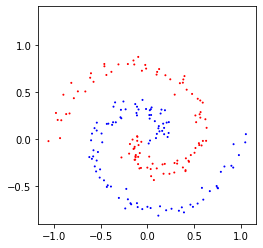

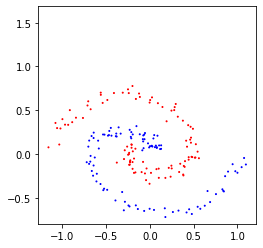

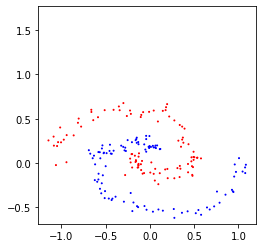

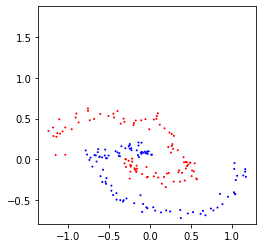

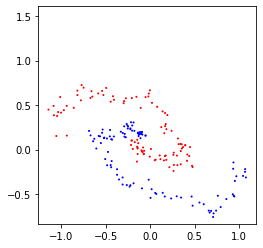

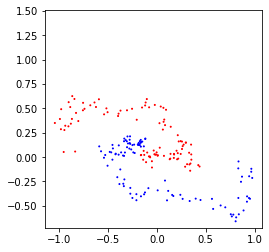

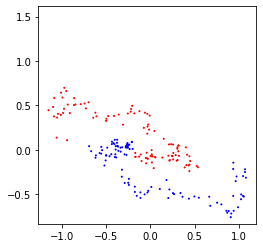

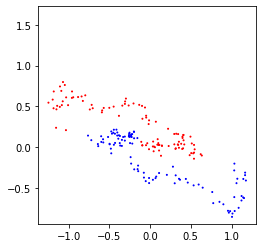

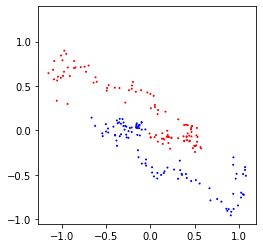

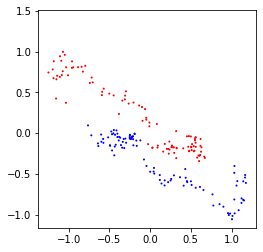

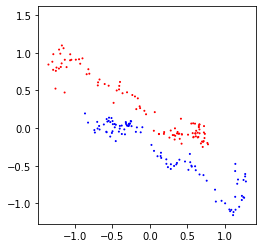

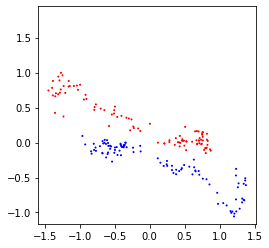

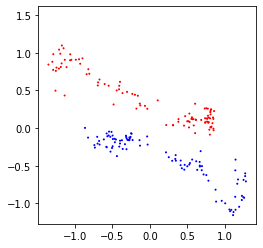

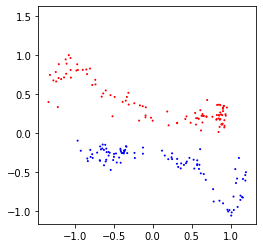

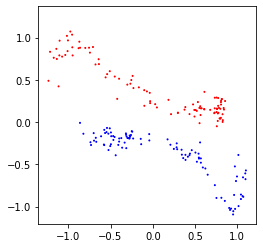

C:  (40000,)


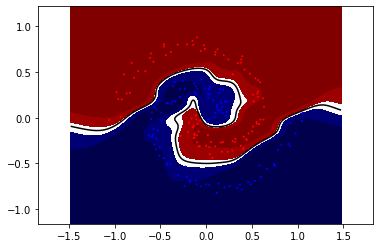

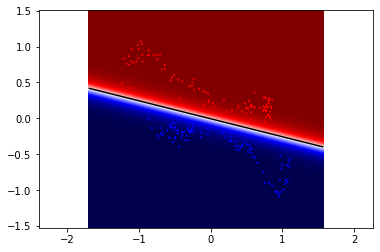

In [59]:
Y_K, Wk, bk, w, mu, arr_z = algoritme(20000, gradient, y0, C, K, sigma, h, Wk, bk, w, mu)

#Fungerer best for mange iterasjoner:

plot_progression(Y_K, np.transpose(C1))
plot_model(forward_function, y0, np.transpose(C1), I)
plot_separation(last_function,Y_K[-1,:,:],C1,I)


**Resultater fra MINST treningen:**